In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pandas_profiling
import tqdm

import os
import gc

pd.set_option('display.max_columns', None)


### Необходимо предобработать данные, выделив репрезентативную группу из 100000 активных пользователей.

In [2]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 5, 
                                    columns=None, 
                                    verbose=False,
                                    info_num_parts=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    list_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    if info_num_parts:
        print(f'Кол-во партиций в папке: {len(list_paths)}')
    start_from = max(0, start_from)
    list_path_to_partitions = list_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
    for path_to_parquet in list_path_to_partitions:
        temp_parquet = pd.read_parquet(path_to_parquet,columns=columns)
        res.append(temp_parquet)
        del temp_parquet
        gc.collect()
    return pd.concat(res).reset_index(drop=True)

In [3]:
!cd /content

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
PATH_TO_TRAIN_TARGET= '/content/drive/MyDrive/data'

In [6]:
import os
len(os.listdir('/content/drive/MyDrive/data'))

50

In [7]:
train_targets = read_parquet_dataset_from_local(PATH_TO_TRAIN_TARGET)
train_targets.head()

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
0,0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,351,34,-1,1
1,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,351,34,0,2
2,0,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,351,34,0,3
3,0,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,348,34,52,4
4,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,337,53,280,5


In [11]:
count_transaction = train_targets[['app_id', 'transaction_number']].groupby('app_id').count()

In [12]:
count_transaction.reset_index(inplace=True)

In [13]:
count_transaction.rename(columns={'transaction_number': 'count'}, inplace=True)

In [14]:
app_activity = count_transaction[count_transaction['count']> 19]

In [15]:
train_df= pd.merge(train_targets, app_activity, on='app_id', how='left')

In [16]:
train_df = train_df[train_df['count']>19]

In [17]:
train_df.shape

(26907283, 21)

### Составить профили временной активности для каждого пользователя 

####суточный (по часам),

In [15]:
train_df.columns

Index(['app_id', 'amnt', 'currency', 'operation_kind', 'card_type',
       'operation_type', 'operation_type_group', 'ecommerce_flag',
       'payment_system', 'income_flag', 'mcc', 'country', 'city',
       'mcc_category', 'day_of_week', 'hour', 'days_before', 'weekofyear',
       'hour_diff', 'transaction_number', 'count'],
      dtype='object')

In [ ]:
train_df['hour'].value_counts().reset_index().sort_values(by='index')

In [18]:
import seaborn as sns
%matplotlib inline

In [19]:
from matplotlib import pyplot as plt

In [76]:
df_hour = pd.pivot_table(train_df, values='transaction_number', index='app_id', columns='hour', aggfunc='count', fill_value=0)
df_hour_max = df_hour.max(axis=1)
df_hour_max = df_hour.max(axis=1)
df_hour = df_hour.div(df_hour_max, axis=0) 

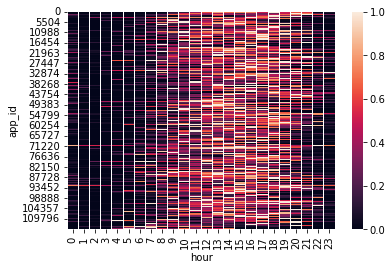

In [77]:
sns.heatmap(df_hour)

####недельный (по дням)

In [80]:
df_week = pd.pivot_table(train_df, values='transaction_number', index='app_id', columns='day_of_week', aggfunc='count', fill_value=0)
df_week_max = df_week.max(axis=1)
df_week_max = df_week.max(axis=1)
df_week = df_week.div(df_week_max, axis=0) 

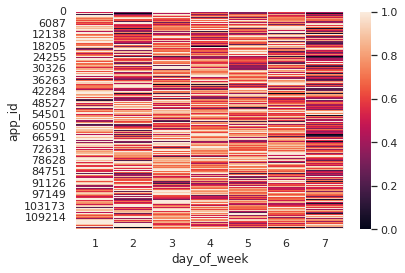

In [41]:
sns.heatmap(df_week)

#### годовой (по месяцам).

In [86]:
train_df['day_of_year'] = (train_df['weekofyear'] - 1) * 7 + train_df['day_of_week'] - 1
train_df['month'] = (train_df['day_of_year'] // 31 + 1)

In [87]:
df_year = pd.pivot_table(train_df, values='transaction_number', index='app_id', columns='month', aggfunc='count', fill_value=0)
df_year_max = df_year.max(axis=1)
df_year_max = df_year.max(axis=1)
df_year = df_year.div(df_week_max, axis=0) 

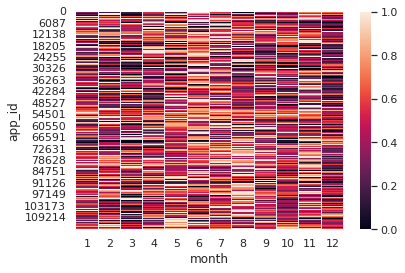

In [46]:
sns.heatmap(df_week)

### Составить профили клиентов по тратам.

In [47]:
train_df.head()

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number,count,day_of_year,month
0,0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,351,34,-1,1,181.0,234,8
1,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,351,34,0,2,181.0,234,8
2,0,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,351,34,0,3,181.0,234,8
3,0,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,348,34,52,4,181.0,232,8
4,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,337,53,280,5,181.0,367,12


In [40]:
train_df['amnt'].describe()

count    2.690728e+07
mean     3.696192e-01
std      9.779671e-02
min      0.000000e+00
25%      3.007032e-01
50%      3.555840e-01
75%      4.265443e-01
max      9.652161e-01
Name: amnt, dtype: float64

In [20]:
def quant(x):
  if x <= 0.3007:
    return 0
  elif x <= 0.3556:
    return 1
  elif x<= 0.4265:
    return 2
  else:
    return 3

In [21]:
train_df['amnt_quant'] =train_df['amnt'].apply(quant)

In [45]:
df_spend = pd.pivot_table(train_df[train_df['income_flag']==1], values='transaction_number', index='app_id', columns='amnt_quant', aggfunc='count', fill_value=0)
df_spend_max = df_spend.max(axis=1)
df_spend_max = df_spend.max(axis=1)
df_spend = df_spend.div(df_spend_max, axis=0) 

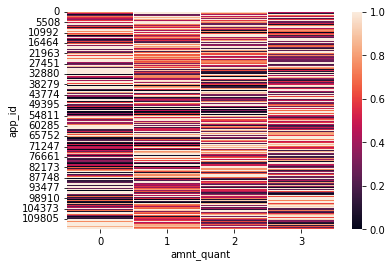

In [46]:
sns.heatmap(df_spend)

###Составить профили интересов, опираясь на mcc-коды транзакций. 

In [26]:
df_interest = pd.pivot_table(train_df, values='transaction_number', index='app_id', columns='mcc_category', aggfunc='count', fill_value=0)
df_interest_max = df_interest.max(axis=1)
df_interest_max = df_interest.max(axis=1)
df_interest = df_interest.div(df_interest_max, axis=0) 

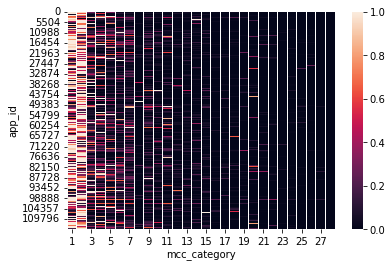

In [27]:
sns.heatmap(df_interest)

### Провести кластеризацию пользователей по всем типам профилей и показать визуализации распределения кластеров в пространстве сниженной размерности. 

In [29]:
#для интересов

In [31]:
from sklearn.cluster import KMeans
# инициализация модели
model = KMeans(n_clusters=3, random_state=42, max_iter=300, n_init=10, verbose=0 )

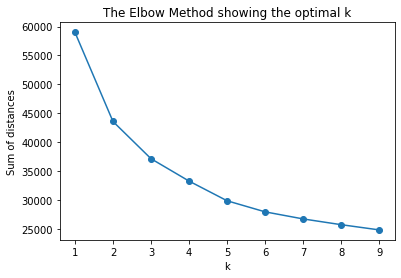

In [59]:
K = range(1, 10)
models_int= [KMeans(n_clusters=k, random_state=42, max_iter=300, n_init=10, verbose=0).fit(df_interest) for k in K]
dist = [model.inertia_ for model in models_int]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [41]:
#По методу каменной осыпи находим оптимальное число кластеров -3 (т. к. между ними меняется угол)

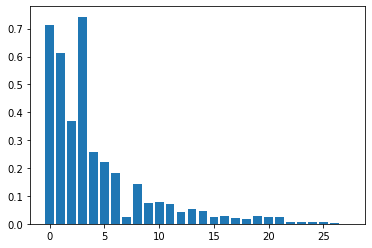

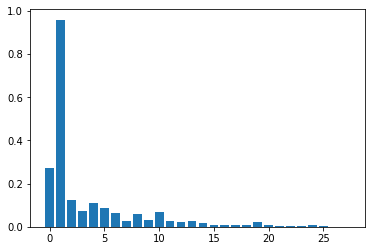

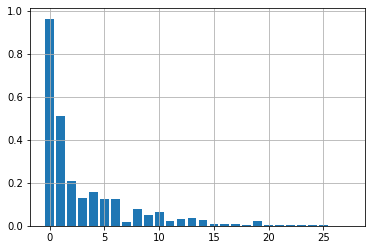

In [74]:
centroid_interest = models_int[2].cluster_centers_ #3 кластера
for i in range(centroid_interest.shape[0]):
  plt.figure()
  plt.bar(list(range(centroid_interest.shape[1])), height=centroid_interest[i])
plt.grid()

In [ ]:
#1 кластер - пользователи больше совершают транзакции  в 1, 2,4 катгориях и в целом совершают много транзакций
# 2 кластер траты превалируют во 2 категории
# 3 кластер -траты превалируют в 1 категории

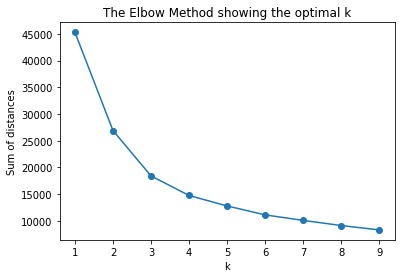

In [61]:
K = range(1, 10)
models_spend= [KMeans(n_clusters=k, random_state=42, max_iter=300, n_init=10, verbose=0).fit(df_spend) for k in K]
dist = [model.inertia_ for model in models_spend]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [49]:
#Опять же оптимальны 3 кластера

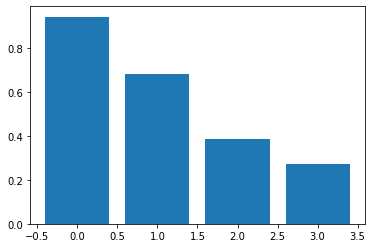

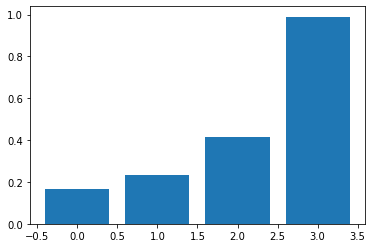

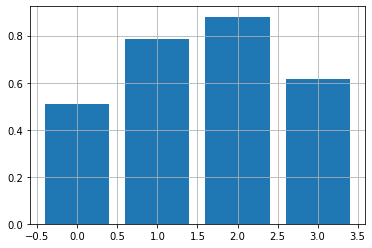

In [75]:
centroid_spend = models_spend[2].cluster_centers_
for i in range(centroid_spend.shape[0]):
  plt.figure()
  plt.bar(list(range(centroid_spend.shape[1])), centroid_spend[i])
plt.grid()

In [ ]:
# 1 клстер - больше всего мелких транзакций, крупных меньше
# 2 кластер - превалируют крупные транзакции
# 3 кластер - превалирует среднее, в целом можно сказать, что поровну

In [ ]:
#для дней

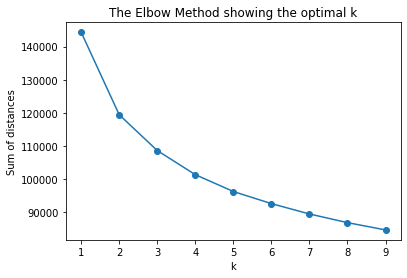

In [78]:
K = range(1, 10)
models_hour= [KMeans(n_clusters=k, random_state=42, max_iter=300, n_init=10, verbose=0).fit(df_hour) for k in K]
dist = [model.inertia_ for model in models_hour]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

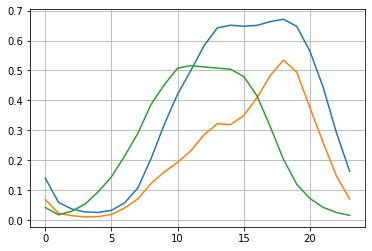

In [79]:
centroid_hour = models_hour[2].cluster_centers_
for i in range(centroid_hour.shape[0]):
  plt.plot(list(range(centroid_hour.shape[1])), centroid_hour[i])
plt.grid()

In [ ]:
# Синий кластер - высокая активность с 13- 19 часов - 
# Оранжевый кластер высокая активность в 6 вечера  - 
# Зеленый кластер - высокая активность с 10 до 15 - 

In [ ]:
#для недель

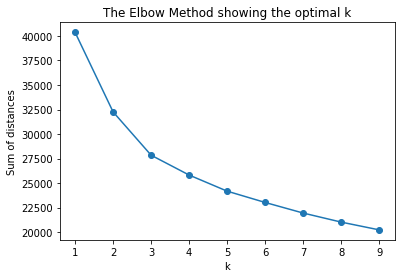

In [81]:
K = range(1, 10)
models_week = [KMeans(n_clusters=k, random_state=42, max_iter=300, n_init=10, verbose=0).fit(df_week) for k in K]
dist = [model.inertia_ for model in models_week]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [82]:
#Опять хорошо подходит 3 кластера

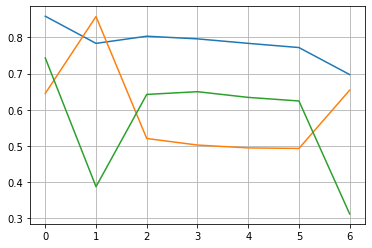

In [84]:
centroid_week = models_week[2].cluster_centers_
for i in range(centroid_week.shape[0]):
  plt.plot(list(range(centroid_week.shape[1])), centroid_week[i])
plt.grid()

In [ ]:
# Синий кластер - нет какой-либо сезонности по дням - возможно магазин проходной работающий без выходных
# Оранжевый кластер - активнее идет работа в начал недели
# Зеленый кластер - снижение активности и повышение к концу недели

In [ ]:
#для месяцев

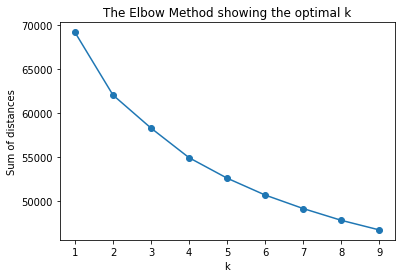

In [90]:
K = range(1, 10)
models_month = [KMeans(n_clusters=k, random_state=42, max_iter=300, n_init=10, verbose=0).fit(df_year) for k in K]
dist = [model.inertia_ for model in models_month]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [91]:
#Более оптимально 4 кластера, по графику

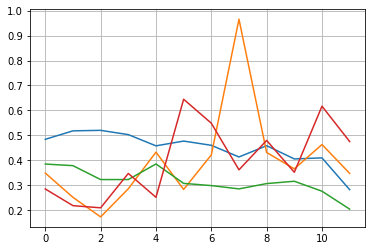

In [94]:
centroid_month = models_month[3].cluster_centers_
for i in range(centroid_month.shape[0]):
  plt.plot(list(range(centroid_month.shape[1])), centroid_month[i])
plt.grid()

In [95]:
# Синий кластер - пик приходится на июль, что-то связаное с летом, например, продажа мороженого/товаров для отдыха
# Оранжевый кластер - пик приходится на вторую половину года (строительство?)
# Зеленый кластер - Всегда одинаковая низкая активность
# Красный кластер - высокая активность транзакций идет весной